In [1]:
import pandas as pd
import PIL
import os
import numpy as np
import skimage.exposure as exposure
import skimage.color as color
import matplotlib.pyplot as plt
from skimage import filters
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from keras.layers import Dropout, BatchNormalization
import platform


2024-03-17 13:43:37.309533: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 13:43:37.527090: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-17 13:43:37.527189: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-17 13:43:37.563916: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-17 13:43:37.644240: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-17 13:43:37.645447: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# importar csv e ler imagens, adicionando elas a um array
csv_file_m1 = "mel1_meta.csv"  
csv_file_m2 = "mel2_meta.csv"  
csv_file_n1 = "nev1_meta.csv"  
csv_file_n2 = "nev2_meta.csv"   

mel1_data = pd.read_csv(csv_file_m1)
mel2_data = pd.read_csv(csv_file_m2)
nev1_data = pd.read_csv(csv_file_n1)
nev2_data = pd.read_csv(csv_file_n2)


In [3]:
# Essa classe sera utilizada para o tratamento de imagens, montá-las como array e aplicação de filtros
class imgProcessor():
    def __init__(self):
        pass

    # Retorna imagem em forma de array com dimensão de 400x400 para reduzir o tempo de treinamento
    def image_as_array(self, image_path, target_size=(400,400)):
        image = PIL.Image.open(image_path)
        resized_image = image.resize(target_size)
        im_array = np.asarray(resized_image)
        return im_array

    # Retorna imagem em alto contraste
    def increase_contrast(self, image):
        im1 = exposure.rescale_intensity(image, in_range=(75, 200))
        return(im1)

    # Retorna imagem com seus canais RGB separados
    def separate_channels(self, image):
      red_channel = image[:, :, 0]
      green_channel = image[:, :, 1]
      blue_channel = image[:, :, 2]
      white_channel = color.rgb2gray(image)
      return red_channel, green_channel, blue_channel, white_channel
    
    # Aplica thresholding à imagem
    def threshold_image(self, image):
        t = filters.threshold_local(image, block_size=45, offset=0.04, method="mean")
        thresholded_image = image > t
        
        return thresholded_image.astype(np.uint8) * 255
    
    def auto_rescale_intensity(self, im, fraction=0.2):  
        hist, bins = np.histogram(im.flatten(), bins=256, range=(0,256))

        cdf = hist.cumsum()
        cdf_normalized = cdf / cdf.max()

        min_val = np.where(cdf_normalized > fraction)[0][0]
        max_val = np.where(cdf_normalized < 1 - fraction)[0][-1]
        
        im_rescaled = exposure.rescale_intensity(im, in_range=(max_val/3, 200 ))

        return im_rescaled

In [4]:
# Função para processar imagens e salvar elas em um array 

def treat_images(dataset, folder):
    img_processor = imgProcessor()
    images_G = []
    images_B = []
    images_R = []
    images_W = []
    images = []
    
    for index, row in dataset.iterrows():
        image_path = row['isic_id']
        
        # tive que adicionar esse condicional, porque se rodar isso no linux ou no windows, o nome do arquivo muda
        if platform.system() == 'Windows':    
            image_path = image_path.replace('.JPG', '.jpg')

        image = img_processor.image_as_array(folder +'/'+ image_path + '.JPG')
        
        image = img_processor.auto_rescale_intensity(image)
        # Separara canais
        R, G, B, W = img_processor.separate_channels(image)
        images_R.append(R)
        images_G.append(G)
        images_B.append(B)
        images_W.append(W)
        
        # imagens e labels
        images.append(image)
        
    # Converter listas para numpy arrays para treinar a rede desta forma
    
    images_R = np.array(images_R)
    images_G = np.array(images_G)
    images_B = np.array(images_B)
    images_W = np.array(images_W)

    return (images, images_R, images_G, images_B, images_W)
   



Apesar de terem metadados nos arquivos csv, não convém aqui utilizá-los, pois eles são de baixa utilidade para o nível de complexidade que acrescentariam à solução do nosso desafio ou contêm informação direta sobre o rótulo resultante, o que vai melhorar a performance da rede neural, mas não é um cenário realista. Dito isso, irei prosseguir com a extração dos dados e tratamento para treinar a rede neural

In [5]:

# importando as imagens como array e salvando em canais separados
mel1_images_c, mel1_images_r, mel1_images_g, mel1_images_b, mel1_images_w  = treat_images(mel1_data, 'Mel1')

mel2_images_c, mel2_images_r, mel2_images_g, mel2_images_b, mel2_images_w  = treat_images(mel2_data, 'Mel2')

nev1_images_c, nev1_images_r, nev1_images_g, nev1_images_b, nev1_images_w  = treat_images(nev1_data, 'Nev1')

nev2_images_c, nev2_images_r, nev2_images_g, nev2_images_b, nev2_images_w  = treat_images(nev2_data, 'Nev2')

Teste para averiguar se a imagem foi corretamente importada e tratada

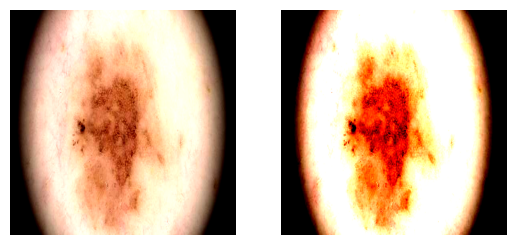

In [6]:
# Teste para averiguar se a imagem foi corretamente importada e tratada
im_process = imgProcessor()

# Aqui, um filtro de exposição é aplicado para aumentar o contraste da imagem
im = nev1_images_c[17]
im1 = im_process.auto_rescale_intensity(im)

plt.subplot(121)
fig = plt.imshow(im)
fig.axes.set_axis_off()
plt.subplot(122)
fig = plt.imshow(im1)
fig.axes.set_axis_off()


Agora que nós sabemos que as imagens estão sendo processadas corretamente, podemos aplicar os filtros e fazer uma análise preliminar do que pode ser feito com os filtros que temos, seguindo os moldes do que fiz na atividade da aula 17.

Veremos duas vezes a aplicação dos filtros de cores e dos filtros de thresholding porque temos uma imagem em alto contraste e uma com o contraste nativo da imagem. 

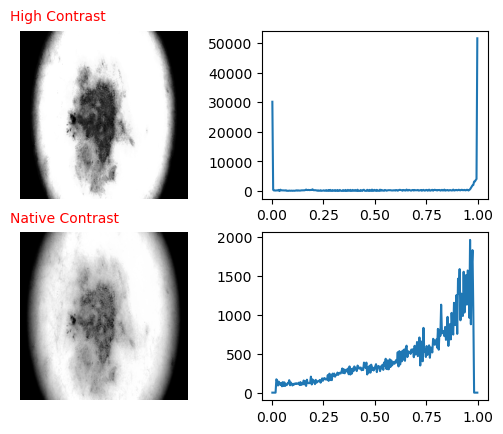

In [7]:
# Aplicando o filtro de cinza e plotando o histograma de exposição

plt.subplot(223)
im_gray = color.rgb2gray(im)
fig = plt.imshow(im_gray, cmap="gray")
fig.axes.set_axis_off()
plt.text(-25,-25, 'Native Contrast', color='red')  
plt.subplot(224)
hist1 = exposure.histogram(im_gray)[::-1]
hist1[1][:5] = hist1[1][-5:] = 0
_ = plt.plot(*hist1)


plt.subplot(221)
im1_gray = color.rgb2gray(im1)
fig = plt.imshow(im1_gray, cmap="gray")
fig.axes.set_axis_off()
plt.text(-25, -25, 'High Contrast', color='red')  
plt.subplot(222)
hist = exposure.histogram(im1_gray)[::-1]
_ = plt.plot(*hist)


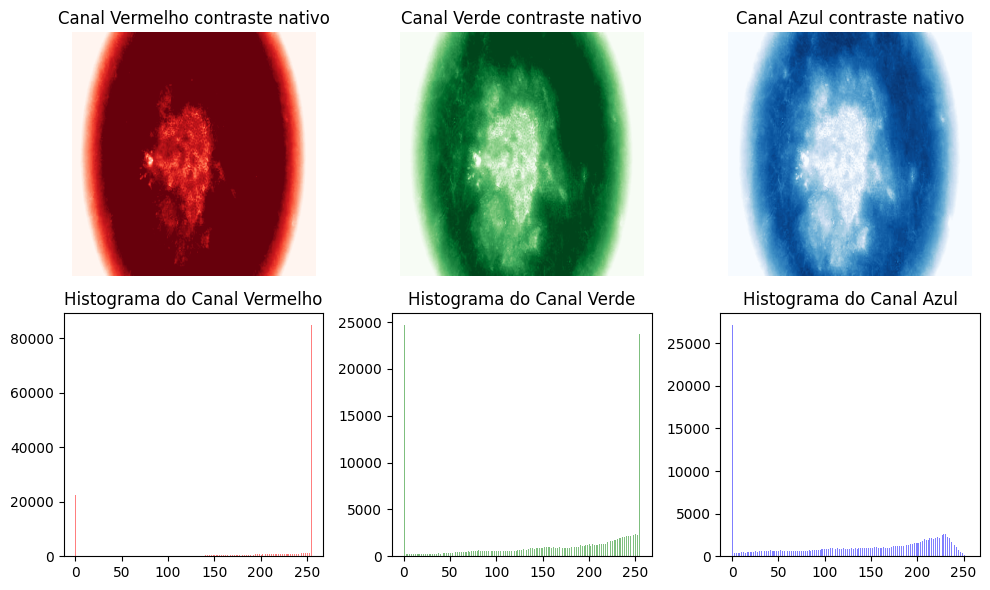

In [56]:
R, G, B, W = imgProcessor.separate_channels('',im)

plt.figure(figsize=(10, 6))

# Red canal
plt.subplot(231)
plt.imshow(R, cmap='Reds')
plt.title('Canal Vermelho contraste nativo')
plt.axis('off')

# Green canal
plt.subplot(232)
plt.imshow(G, cmap='Greens')
plt.title('Canal Verde contraste nativo')
plt.axis('off')

# canal
plt.subplot(233)
plt.imshow(B, cmap='Blues')
plt.title('Canal Azul contraste nativo')
plt.axis('off')






# Histogramas
plt.subplot(234)
plt.hist(np.ravel(R), bins=256, color='red', alpha=0.5)
plt.title('Histograma do Canal Vermelho')

plt.subplot(235)
plt.hist(np.ravel(G), bins=256, color='green', alpha=0.5)
plt.title('Histograma do Canal Verde')

plt.subplot(236)
plt.hist(np.ravel(B), bins=256, color='blue', alpha=0.5)
plt.title('Histograma do Canal Azul')

plt.tight_layout()
plt.show()

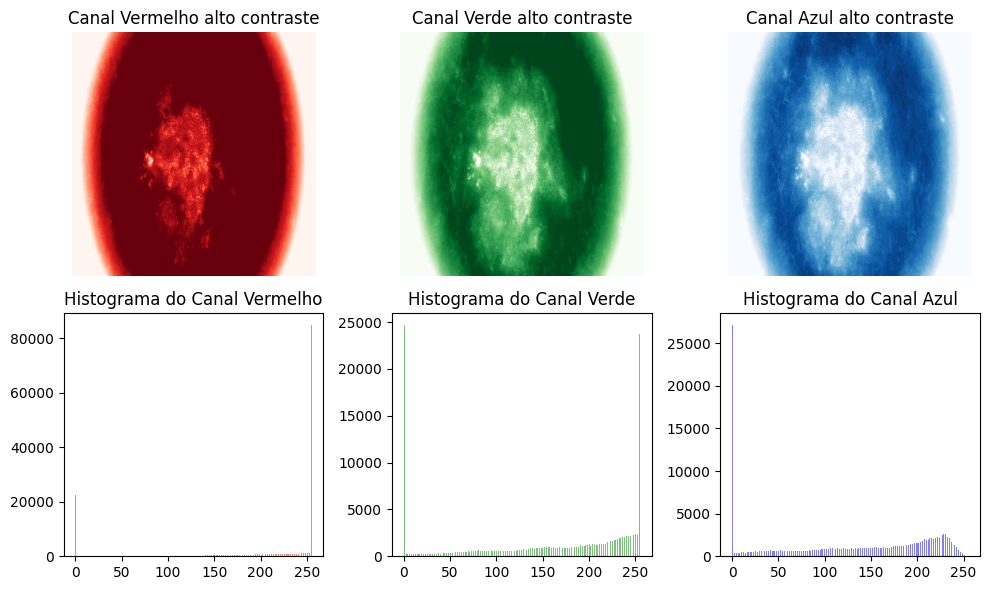

In [57]:
plt.figure(figsize=(10, 6))

# Red canal
plt.subplot(231)
plt.imshow(R, cmap='Reds')
plt.title('Canal Vermelho alto contraste')
plt.axis('off')

# Green canal
plt.subplot(232)
plt.imshow(G, cmap='Greens')
plt.title('Canal Verde alto contraste')
plt.axis('off')

# canal
plt.subplot(233)
plt.imshow(B, cmap='Blues')
plt.title('Canal Azul alto contraste')
plt.axis('off')






# Histogramas
plt.subplot(234)
plt.hist(np.ravel(R), bins=256, color='red', alpha=0.5)
plt.title('Histograma do Canal Vermelho')

plt.subplot(235)
plt.hist(np.ravel(G), bins=256, color='green', alpha=0.5)
plt.title('Histograma do Canal Verde')

plt.subplot(236)
plt.hist(np.ravel(B), bins=256, color='blue', alpha=0.5)
plt.title('Histograma do Canal Azul')
 
plt.tight_layout()
plt.show()

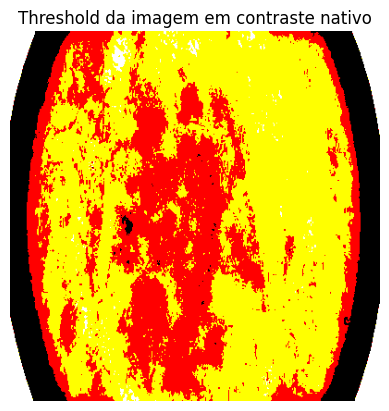

In [58]:
im_threshold = im_process.threshold_image(im)

fig = plt.imshow(im_threshold)
plt.title('Threshold da imagem em contraste nativo')
fig.axes.set_axis_off()


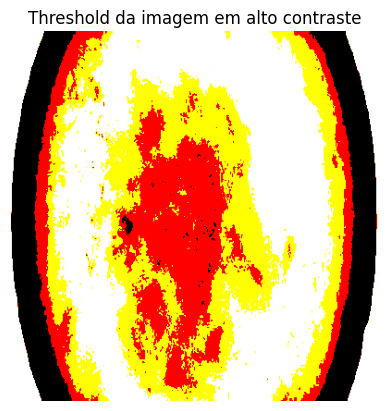

In [59]:
im1_threshold = im_process.threshold_image(im1)

fig = plt.imshow(im1_threshold)
plt.title('Threshold da imagem em alto contraste')
fig.axes.set_axis_off()

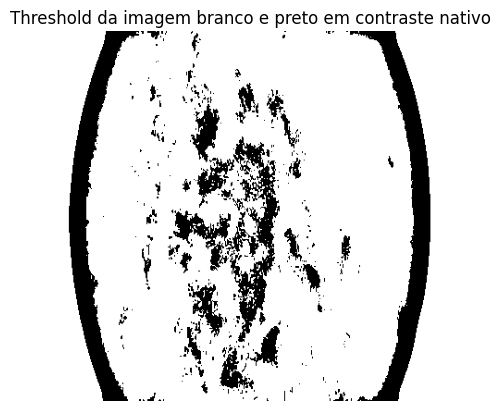

In [60]:
im_threshold = im_process.threshold_image(im_gray)

fig = plt.imshow(im_threshold, cmap='gray')
plt.title('Threshold da imagem branco e preto em contraste nativo')
fig.axes.set_axis_off()

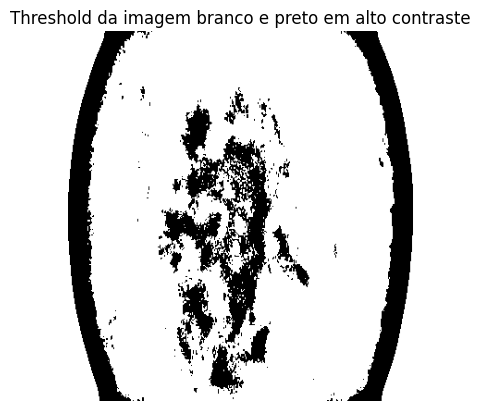

In [61]:
im1_threshold = im_process.threshold_image(im1_gray)

fig = plt.imshow(im1_threshold, cmap='gray')
plt.title('Threshold da imagem branco e preto em alto contraste')
fig.axes.set_axis_off()


Vistos agora os efeitos de cada tratamento de imagem nas imagens do banco de dados, vamos agora juntar os dados que estavam originalmente separados em 4 datasets diferentes em um só, randomizando-os para garantir uma distribuição aleatória. Ao analisar os dados, identificaremos as informações que podem servir como rótulo para os quatro conjuntos de dados de interesse. Essas informações podem ser encontradas na coluna de diagnóstico, onde os registros podem ser classificados como "melanoma" ou outro diagnóstico relevante, ou na coluna que indica se é "benigno" ou "maligno", com essas duas opções possíveis.

Considerando que os rótulos são idênticos para cada arquivo individualmente, para otimizar o processo de importação e tratamento dos dados, os rótulos de cada arquivo serão postos em um np array.

Tendo em vista também de que as imagens estão em baixa resolução, o thresolding apresentou vários artefatos, e portanto não será utilizado.


In [8]:
# Essa função de separação une as imagens separadas
# E retorna elas separadas em grupos de treino e teste, junto com os seus rótulos  
def create_combined_data(mel1_images, mel2_images, nev1_images, nev2_images):
    mel1_labels = np.array(['malignant'] * 50)
    mel2_labels = np.array(['malignant'] * 50)
    nev1_labels = np.array(['benign'] * 50)
    nev2_labels = np.array(['benign'] * 50)

    combined_labels = []
    combined_data = []

    for n, i in enumerate(mel1_images):
        combined_data.append(i)
        combined_labels.append(mel1_labels[n])

        combined_data.append(nev1_images[n])
        combined_labels.append(nev1_labels[n])

        combined_data.append(mel2_images[n])
        combined_labels.append(mel2_labels[n])

        combined_data.append(nev2_images[n])
        combined_labels.append(nev2_labels[n])

    combined_data_shuffled, combined_labels_shuffled = shuffle(combined_data, combined_labels)

    return train_test_split(combined_data_shuffled, combined_labels_shuffled, test_size=0.3, random_state=62)


In [63]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_c, mel2_images_c, nev1_images_c, nev2_images_c)

print(test_labels)
print(len(train_labels)/(len(test_labels)+len(train_labels)))

['malignant', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'malignant', 'benign', 'malignant', 'benign', 'malignant', 'benign', 'malignant', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'benign', 'benign', 'benign', 'benign', 'benign', 'benign', 'malignant', 'benign', 'malignant', 'malignant', 'benign', 'malignant', 'malignant', 'benign', 'malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'malignant', 'malignant', 'benign', 'benign', 'malignant', 'malignant', 'malignant', 'malignant']
0.7


Nesse teste com as imagens coloridas, ao imprimir os rótulos, vemos que obtemos exito embaralhá-los. Com 70% do conjunto sendo para teste.

Agora que já conseguimos processar e agrupar as imagens de forma que podemos alimentar ela para uma rede neural, precisamos montar nossa RNC.

A única diferença entre as redes, é o tratamento dos vetores, que são dimensionalmente adequados para a rede no modelo por canal. 

Extração de características: A rede utiliza filtros convolucionais para detectar padrões e características importantes nas imagens, como bordas, texturas e formas. Esses filtros são aplicados em várias camadas, com camadas de pooling para reduzir a dimensionalidade e preservar as características mais importantes.

Classificação: Após a extração de características, as informações são "achatadas" em um vetor unidimensional e passadas por camadas densas, que funcionam como classificadores. Essas camadas densas aprendem a relacionar as características extraídas às classes de interesse, utilizando a função de ativação softmax para calcular as probabilidades de pertencer a cada classe.

In [15]:
from sklearn.preprocessing import LabelEncoder
from keras import layers, models

def train_model_full(X_train, X_test, y_train, y_test):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Definir topologia da rede neural
    def create_model(input_shape, num_classes):
        model = models.Sequential([
            layers.Reshape((input_shape[0], input_shape[1], 1), input_shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        return model

    # Criar modelo
    input_shape = X_train.shape[1:] 
    num_classes = 2
    model = create_model(input_shape, num_classes)

    # Compilar modelo
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Treinar modelo e armazenar historico
    history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded))


     # Avaliar modelo
    test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
    print(f'\nTest accuracy: {test_acc:.2f}\nTest Loss{test_loss:.2f}')

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  

    plt.legend()
    plt.show()

    # Estatísticas do modelo
    test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
    print('Test accuracy:', test_acc)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # matriz confusão 
    cm = confusion_matrix(y_test_encoded, y_pred_classes)


    labels = label_encoder.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [10]:

def train_model_chanel(X_train, X_test, y_train, y_test):
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(-1, X_test.shape[1], X_test.shape[2], 1)

    # Definir topologia da rede neural
    def create_model(input_shape, num_classes):
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(num_classes, activation='softmax')
        ])
        return model

    # Criar modelo
    input_shape = X_train.shape[1:]
    num_classes = 2
    model = create_model(input_shape, num_classes)

    # Compilar modelo
    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

    # Treinar modelo e armazenar historico
    history = model.fit(X_train, y_train_encoded, epochs=10, validation_data=(X_test, y_test_encoded))

    # Avaliar modelo
    test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
    print(f'\nTest accuracy: {test_acc:.2f}\nTest Loss{test_loss:.2f}')

    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  

    plt.legend()
    plt.show()

    # Estatísticas do modelo
    test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
    print('Test accuracy:', test_acc)

    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # matriz confusão 
    cm = confusion_matrix(y_test_encoded, y_pred_classes)


    labels = label_encoder.classes_
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


    

In [ ]:
print(errore)

Modelo treinado com canal <span style='color:red'>Vermelho</span>


C:\Users\vini0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5922 - loss: 1004.5768 - val_accuracy: 0.4000 - val_loss: 314.2128
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5343 - loss: 142.4535 - val_accuracy: 0.4000 - val_loss: 153.1050
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.5774 - loss: 57.2437 - val_accuracy: 0.6333 - val_loss: 9.4029
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5778 - loss: 7.6428 - val_accuracy: 0.6500 - val_loss: 0.9396
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8114 - loss: 0.5820 - val_accuracy: 0.6500 - val_loss: 4.4517
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8075 - loss: 2.1002 - val_accuracy: 0.7000 - val_loss: 3.3535
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8183 - loss: 1.2849 - val_accuracy: 0.7167 - val_loss: 1.6976
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9259 - loss: 0.1745 - val_accuracy: 0.7000 - val_loss: 1.980

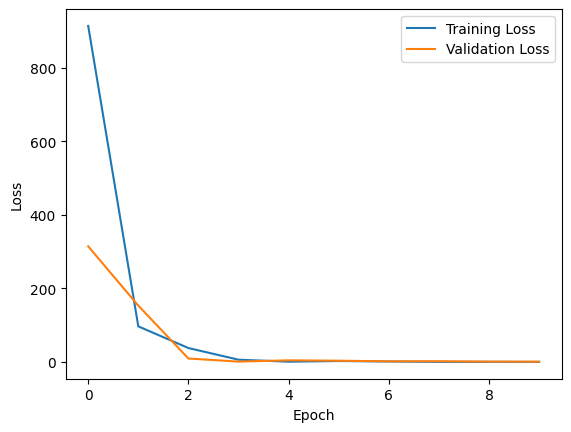

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 465ms/step - accuracy: 0.7736 - loss: 0.9989
Test accuracy: 0.8166666626930237
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 516ms/step


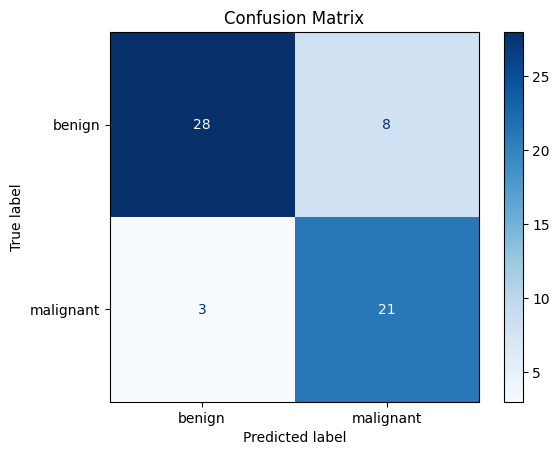

In [69]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_r, mel2_images_r, nev1_images_r, nev2_images_r)

train_data = np.array(train_data) 
test_data = np.array(test_data) 
train_labels = np.array(train_labels)  
test_labels = np.array(test_labels) 
train_model_chanel(train_data, test_data, train_labels, test_labels)

Modelo treinado com canal <span style='color:azul'>Azul</span>


Epoch 1/10


C:\Users\vini0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.5241 - loss: 2070.6807 - val_accuracy: 0.6333 - val_loss: 43.0019
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5444 - loss: 31.3804 - val_accuracy: 0.3667 - val_loss: 66.0706
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7001 - loss: 23.7663 - val_accuracy: 0.7333 - val_loss: 3.2568
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8796 - loss: 1.1018 - val_accuracy: 0.6500 - val_loss: 7.6802
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.8953 - loss: 0.8737 - val_accuracy: 0.8833 - val_loss: 0.9910
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.9840 - loss: 0.1035 - val_accuracy: 0.9000 - val_loss: 0.9478
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 1.0000 - loss: 0.0141 - val_accuracy: 0.8667 - val_loss: 1.1135
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.8333 - val_loss: 1.2933
Epoch 9/10
5

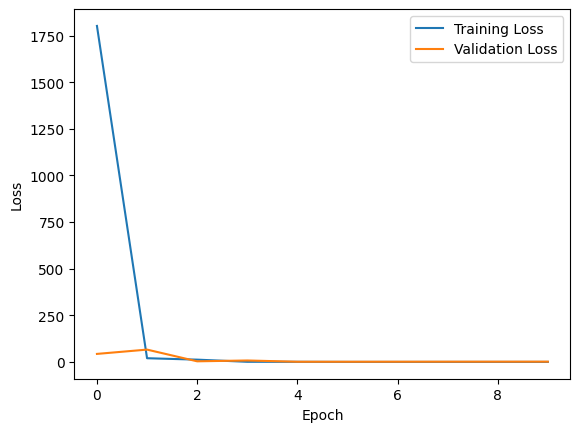

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 469ms/step - accuracy: 0.8368 - loss: 1.4351
Test accuracy: 0.8333333134651184
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step


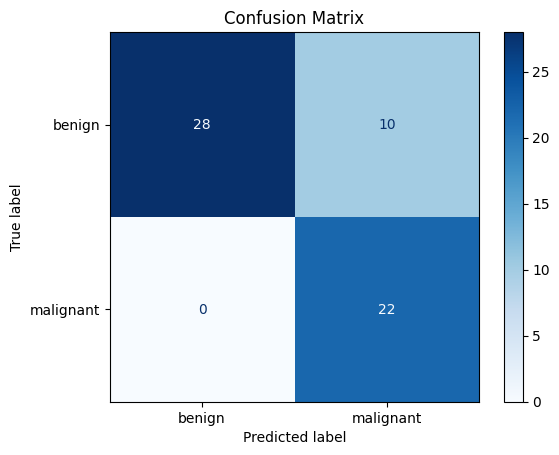

In [72]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_b, mel2_images_b, nev1_images_b, nev2_images_b)

train_data = np.array(train_data) 
test_data = np.array(test_data) 
train_labels = np.array(train_labels)  
test_labels = np.array(test_labels) 
train_model_chanel(train_data, test_data, train_labels, test_labels)

Modelo treinado com canal <span style='color:green'>Verde</span>

Epoch 1/10


C:\Users\vini0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.4833 - loss: 1766.0652 - val_accuracy: 0.7667 - val_loss: 0.9916
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.5837 - loss: 13.5919 - val_accuracy: 0.6000 - val_loss: 14.1833
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6999 - loss: 5.0759 - val_accuracy: 0.7333 - val_loss: 2.2220
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8360 - loss: 0.8039 - val_accuracy: 0.8333 - val_loss: 0.4498
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9109 - loss: 0.2861 - val_accuracy: 0.8500 - val_loss: 0.3887
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9712 - loss: 0.1360 - val_accuracy: 0.8333 - val_loss: 0.4740
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.9722 - loss: 0.0710 - val_accuracy: 0.8667 - val_loss: 0.5994
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9883 - loss: 0.0342 - val_accuracy: 0.8333 - val_loss: 0.5492
Epoch 9/10
5/5

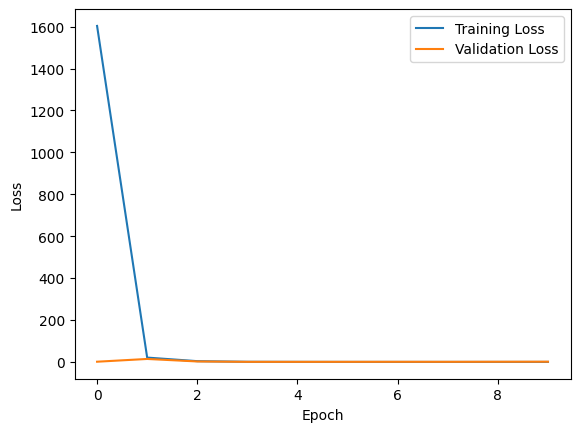

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step - accuracy: 0.8375 - loss: 1.2776
Test accuracy: 0.8500000238418579
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 714ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002BAB5422340> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step


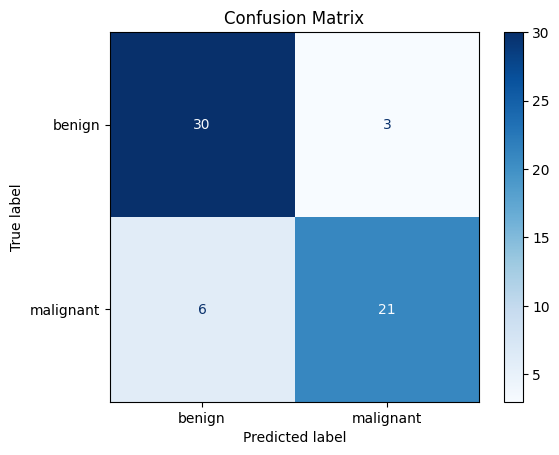

In [73]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_g, mel2_images_g, nev1_images_g, nev2_images_g)

train_data = np.array(train_data) 
test_data = np.array(test_data) 
train_labels = np.array(train_labels)  
test_labels = np.array(test_labels) 
train_model_chanel(train_data, test_data, train_labels, test_labels)

Modelo treinado com escala de cinza

C:\Users\vini0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.4664 - loss: 9.0489 - val_accuracy: 0.4500 - val_loss: 0.8215
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.6851 - loss: 0.6485 - val_accuracy: 0.6000 - val_loss: 0.8361
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7194 - loss: 0.5740 - val_accuracy: 0.7000 - val_loss: 0.5234
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.7721 - loss: 0.4032 - val_accuracy: 0.7167 - val_loss: 0.4752
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.8105 - loss: 0.3511 - val_accuracy: 0.7333 - val_loss: 0.4623
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8326 - loss: 0.3142 - val_accuracy: 0.7167 - val_loss: 0.4586
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.9026 - loss: 0.2313 - val_accuracy: 0.7833 - val_loss: 0.5264
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8471 - loss: 0.3156 - val_accuracy: 0.8167 - val_loss: 0.4974
Epoch 9/

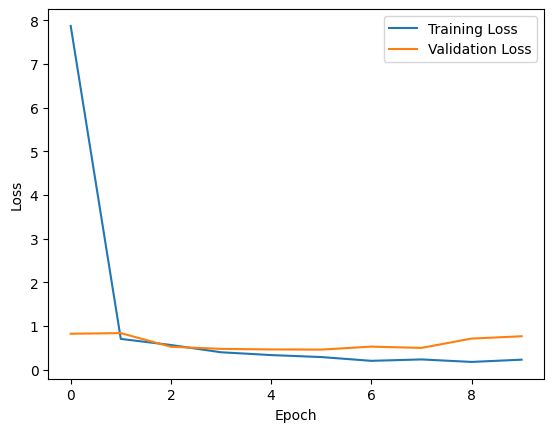

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step - accuracy: 0.7507 - loss: 0.8843
Test accuracy: 0.7666666507720947
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step


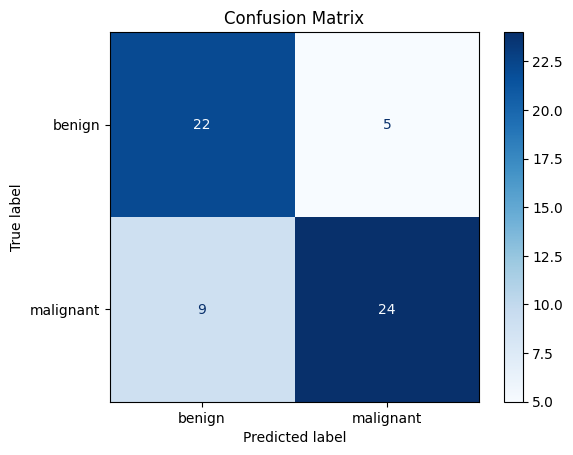

In [91]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_w, mel2_images_w, nev1_images_w, nev2_images_w)

train_data = np.array(train_data) 
test_data = np.array(test_data) 
train_labels = np.array(train_labels)  
test_labels = np.array(test_labels) 
train_model_full(train_data, test_data, train_labels, test_labels)

Agrupando os resultados de cada canal para avaliar:

        Canal Vermelho  (accuracy: 0.7736 || loss: 0.9989 || Test accuracy: 0.8167)
        Canal Azul      (accuracy: 0.8368 || loss: 1.4351 || Test accuracy: 0.8333)
        Canal Verde     (accuracy: 0.8375 || loss: 1.2776 || Test accuracy: 0.8500)
        Tons de Cinza   (accuracy: 0.7507 || loss: 0.8843 || Test accuracy: 0.7667)

Avaliando os resultados, vemos que em todos os canais, obtivemos um resultado positivo, superando um classificador aleatório e com resultados em volta de 80% de acurácia para todos os canais testados. Observa-se que acontece um fenômeno peculiar, onde acontece um loss menor para redes com acurácia menor. Abaixo, os testes foram refeitos, mas utilizaram gráficos de perda em escala log para melhorar a visualização desses acontecimentos, trazendo resultados diferentes e mais informações para analisar-mos.

Imagens em escala de cinza (gráfico log)

Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 4.6140 - accuracy: 0.5143 - val_loss: 2.1682 - val_accuracy: 0.4833
Epoch 2/10
5/5 [==============================] - 14s 3s/step - loss: 1.1348 - accuracy: 0.5214 - val_loss: 0.6652 - val_accuracy: 0.4833
Epoch 3/10
5/5 [==============================] - 14s 3s/step - loss: 0.6840 - accuracy: 0.5857 - val_loss: 0.5882 - val_accuracy: 0.4833
Epoch 4/10
5/5 [==============================] - 14s 3s/step - loss: 0.6505 - accuracy: 0.6500 - val_loss: 0.7172 - val_accuracy: 0.4833
Epoch 5/10
5/5 [==============================] - 14s 3s/step - loss: 0.6651 - accuracy: 0.5571 - val_loss: 0.6226 - val_accuracy: 0.6833
Epoch 6/10
5/5 [==============================] - 14s 3s/step - loss: 0.6077 - accuracy: 0.6929 - val_loss: 0.6077 - val_accuracy: 0.7500
Epoch 7/10
5/5 [==============================] - 14s 3s/step - loss: 0.5782 - accuracy: 0.7357 - val_loss: 0.5619 - val_accuracy: 0.7500
Epoch 8/10
5/5 [==================

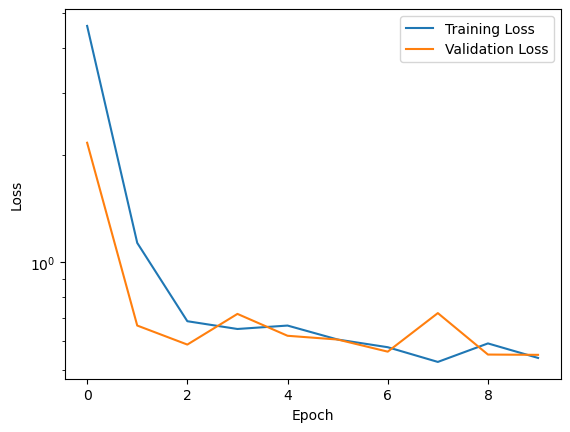

2/2 [==============================] - 1s 571ms/step - loss: 0.5504 - accuracy: 0.8000
Test accuracy: 0.800000011920929
2/2 [==============================] - 1s 568ms/step


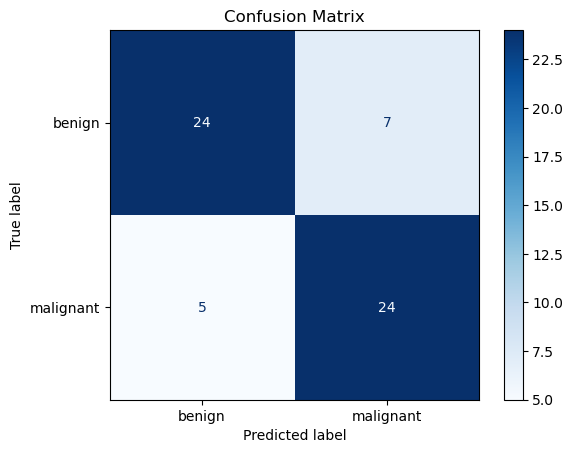

In [16]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_w, mel2_images_w, nev1_images_w, nev2_images_w)

train_data = np.array(train_data) 
test_data = np.array(test_data) 
train_labels = np.array(train_labels)  
test_labels = np.array(test_labels) 
train_model_full(train_data, test_data, train_labels, test_labels)

Imagens em <span style='color:green'>verde</span> (gráfico log)


Epoch 1/10
5/5 [==============================] - 17s 3s/step - loss: 1739.1978 - accuracy: 0.5214 - val_loss: 43.0718 - val_accuracy: 0.6500
Epoch 2/10
5/5 [==============================] - 16s 3s/step - loss: 16.8207 - accuracy: 0.6929 - val_loss: 0.8950 - val_accuracy: 0.6667
Epoch 3/10
5/5 [==============================] - 16s 3s/step - loss: 0.2620 - accuracy: 0.9000 - val_loss: 0.5177 - val_accuracy: 0.8167
Epoch 4/10
5/5 [==============================] - 15s 3s/step - loss: 0.0777 - accuracy: 0.9857 - val_loss: 0.5571 - val_accuracy: 0.8500
Epoch 5/10
5/5 [==============================] - 16s 3s/step - loss: 0.0254 - accuracy: 0.9929 - val_loss: 0.6194 - val_accuracy: 0.8500
Epoch 6/10
5/5 [==============================] - 15s 3s/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9118 - val_accuracy: 0.8333
Epoch 7/10
5/5 [==============================] - 15s 3s/step - loss: 0.0114 - accuracy: 0.9929 - val_loss: 1.0097 - val_accuracy: 0.8000
Epoch 8/10
5/5 [=============

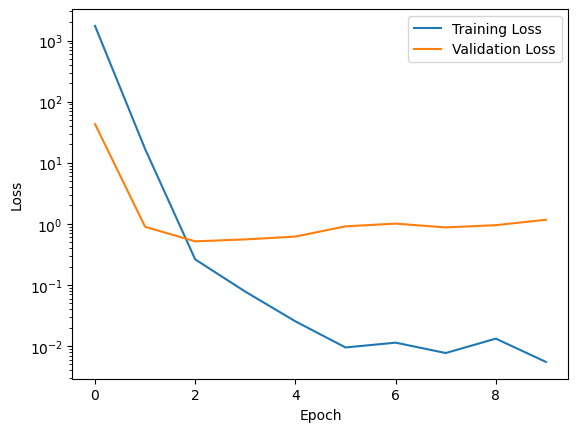

2/2 [==============================] - 1s 585ms/step - loss: 1.1686 - accuracy: 0.8333
Test accuracy: 0.8333333134651184
2/2 [==============================] - 1s 576ms/step


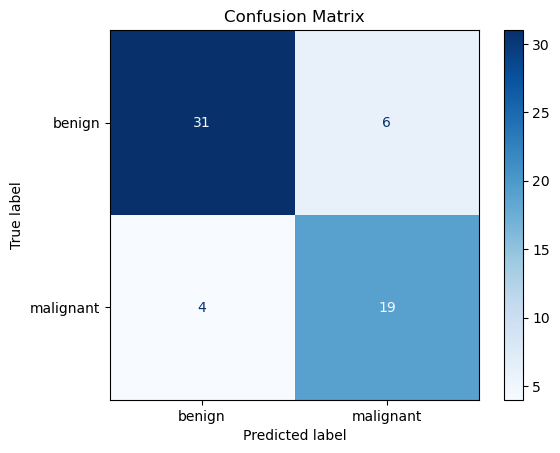

In [29]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_g, mel2_images_g, nev1_images_g, nev2_images_g)

train_data = np.array(train_data) 
test_data = np.array(test_data) 
train_labels = np.array(train_labels)  
test_labels = np.array(test_labels) 
train_model_chanel(train_data, test_data, train_labels, test_labels)

Imagens em <span style='color:red'>vermelho</span> (gráfico log)


Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 3509.2996 - accuracy: 0.5857 - val_loss: 56.9289 - val_accuracy: 0.5500
Epoch 2/10
5/5 [==============================] - 16s 3s/step - loss: 85.7930 - accuracy: 0.4786 - val_loss: 56.7192 - val_accuracy: 0.4500
Epoch 3/10
5/5 [==============================] - 15s 3s/step - loss: 18.7583 - accuracy: 0.5714 - val_loss: 13.0912 - val_accuracy: 0.6667
Epoch 4/10
5/5 [==============================] - 15s 3s/step - loss: 18.9755 - accuracy: 0.6857 - val_loss: 4.2727 - val_accuracy: 0.7500
Epoch 5/10
5/5 [==============================] - 14s 3s/step - loss: 1.2219 - accuracy: 0.8286 - val_loss: 2.3545 - val_accuracy: 0.7000
Epoch 6/10
5/5 [==============================] - 14s 3s/step - loss: 0.3674 - accuracy: 0.8786 - val_loss: 1.6971 - val_accuracy: 0.7167
Epoch 7/10
5/5 [==============================] - 14s 3s/step - loss: 0.0948 - accuracy: 0.9500 - val_loss: 1.7451 - val_accuracy: 0.7667
Epoch 8/10
5/5 [=========

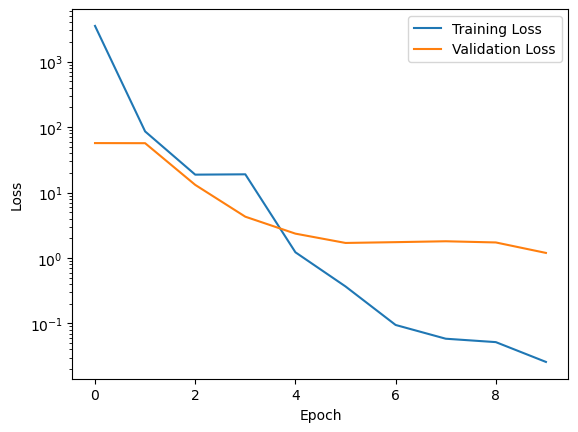

2/2 [==============================] - 1s 556ms/step - loss: 1.1953 - accuracy: 0.7833
Test accuracy: 0.7833333611488342
2/2 [==============================] - 1s 557ms/step


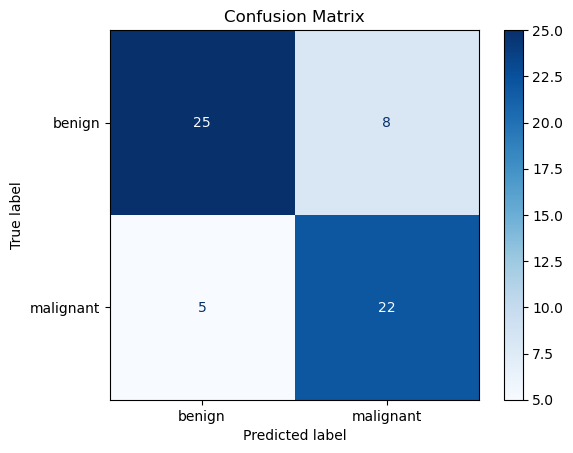

In [14]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_r, mel2_images_r, nev1_images_r, nev2_images_r)

train_data = np.array(train_data) 
test_data = np.array(test_data) 
train_labels = np.array(train_labels)  
test_labels = np.array(test_labels) 
train_model_chanel(train_data, test_data, train_labels, test_labels)

Imagens em <span style='color:blue'>Azul</span> (gráfico log)

Epoch 1/10
5/5 [==============================] - 16s 3s/step - loss: 694.3748 - accuracy: 0.5500 - val_loss: 27.7081 - val_accuracy: 0.5333
Epoch 2/10
5/5 [==============================] - 15s 3s/step - loss: 12.9792 - accuracy: 0.6714 - val_loss: 1.4359 - val_accuracy: 0.8500
Epoch 3/10
5/5 [==============================] - 14s 3s/step - loss: 1.0928 - accuracy: 0.8286 - val_loss: 1.9147 - val_accuracy: 0.7500
Epoch 4/10
5/5 [==============================] - 14s 3s/step - loss: 0.8524 - accuracy: 0.8786 - val_loss: 1.7582 - val_accuracy: 0.8333
Epoch 5/10
5/5 [==============================] - 14s 3s/step - loss: 0.0442 - accuracy: 0.9857 - val_loss: 1.4158 - val_accuracy: 0.8167
Epoch 6/10
5/5 [==============================] - 14s 3s/step - loss: 0.0463 - accuracy: 0.9857 - val_loss: 1.4640 - val_accuracy: 0.8333
Epoch 7/10
5/5 [==============================] - 15s 3s/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 1.3553 - val_accuracy: 0.8667
Epoch 8/10
5/5 [==============

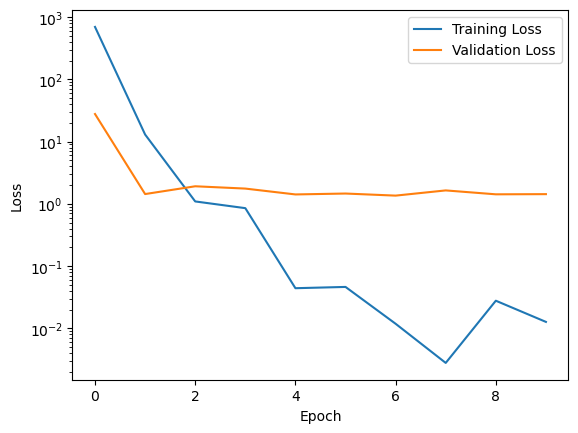

2/2 [==============================] - 1s 575ms/step - loss: 1.4314 - accuracy: 0.8167
Test accuracy: 0.8166666626930237
2/2 [==============================] - 1s 581ms/step


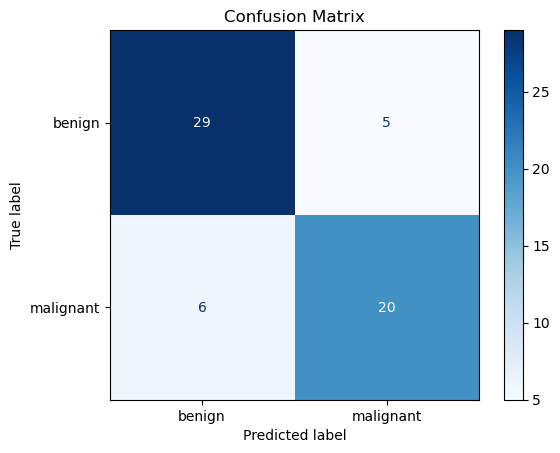

In [11]:
train_data, test_data, train_labels, test_labels = create_combined_data(mel1_images_b, mel2_images_b, nev1_images_b, nev2_images_b)

train_data = np.array(train_data) 
test_data = np.array(test_data) 
train_labels = np.array(train_labels)  
test_labels = np.array(test_labels) 
train_model_chanel(train_data, test_data, train_labels, test_labels)

Ao avaliar esses gráficos, podemos ver melhor que é possível de que em algumas das nossas redes ainda não haja convergência em 10 épocas, em outras, como na azul, podemos ver que há uma rápida convergência. Todas as redes trouxeram resultados positivos na classificação das imagens, superior a 50%. Agora com um melhor contexto de como cada rede se comporta, podemos avaliar melhor.

Há uma certa discrepância entre os resultados obtidos inicialmente e posteriormente, pois os dados são separados aleatoriamente, então irei eleger como o melhor modelo, aquele que foi mais consistente em apresentar um bom resultado.

        Canal Vermelho anterior   (Train accuracy: 0.7736 || Test loss: 0.9989 || Test accuracy: 0.8167)
        Canal Vermelho posterior  (Train accuracy: 0.7833 || Test loss: 1.1953 || Test accuracy: 0.7833)

        Canal Azul anterior       (Train accuracy: 0.8368 || Test loss: 1.4351 || Test accuracy: 0.8333)
        Canal Azul posterior      (Train accuracy: 0.8167 || Test loss: 1.4314 || Test accuracy: 0.8167)

        Canal Verde anterior      (Train accuracy: 0.8375 || Test loss: 1.2776 || Test accuracy: 0.8500)
        Canal Verde posterior     (Train accuracy: 0.8333 || Test loss: 1.1686 || Test accuracy: 0.8333)

        Tons de Cinza anterior    (Train accuracy: 0.7507 || Test loss: 0.8843 || Test accuracy: 0.7667)
        Tons de Cinza posterior   (Train accuracy: 0.8000 || Test loss: 0.5504 || Test accuracy: 0.8000)
        
Vemos que nos conjuntos de treino, os canais azul e verde são os mais consistentes, apesar de terem uma perda associada maior quando comparados com os resultados dos outros 2 grupos testados. 

Os canais que apresentaram pior performance, vermelho e cinza apresentam uma perda menor, porém não trouxeram resultados consistentes, e apresentaram pior acurácia. 

Observando o gráfico do vermelho, verifica-se que a rede pode ainda não ter chegado ao seu ponto ótimo, pois seu gráfico de perda ainda está decrescendo, o que pode significar que há a possibilidade de melhorar a sua performance, o que não acontece com o cinza. 


Os canais que apresentaram a melhor performance, verde e azul apresentam uma perda maior, no entanto, trouxeram resultados consistentes, e apresentaram a melhor acurácia, se tornando assim os melhores canais para se treinar essa rede. Dentre os dois, o que apresentou melhor perda e melhor resultado foi o verde.
